# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/woman.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 30                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
iterations = 10

;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean + rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))
# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCs+F29pgP4vXE0xb2Kppq9gVNYvZnD7bwfnRI9wbyxPQv9HT6eDlw+zPR1Pl4qdT6o8Go+RptWPpxpTz2G6Sm9JXrxvJY6C75g0Wy+J5zuvbt4u70jVbC6nYoUveIVnTuV2pw9WnR1PfcHLbzv9Pc7mMBfvSJZ+rxqul69lS70vVmJ3L3Y9BG+7DgTvreabr09HuW8tvQbPESb4z3rqBo+SGZiPrVfUj4xJIA+qOOOPl0B/D1DLNY8ita5PJVYP7tg4gu+JQWBvkCLXr4MPMu9w13pvM50fr2yE0q9Q9kUPS13az2BSsC7LKSSPOO9JL21qUK9/dPJvd+ykbxiIg++G6X8vdnyEL7zMoC92gmIvUA5Mj0fFIc9N7xqPqdiWD6mYZU+JWlcPqsIQz4sxFs9HrVkPZ69eD0NTiu9V+hjvl1sVr68Tum93IXBvXEPNb3cjsm8pSJmOvzimT105ZI96PUMPe4oSr310Le7uFqau8kVy71brT6+NYdYvelN0L1RaL69kXSIvKNLXLuVqKw95eDpPdTdKj5faG0+WYt6PnIrhD6mshc9X6/LPHpAWT0KVpq8R7YpvjXznL4u2Cq+XKLrvbaOsL3j5tm9B6FWvVvNpzzcVmU8o7BDPV2jrjwcn8S7Rl8APVzxRL3q6cC9Q8XcvTYKS70cV4C9EE6ZvWQWvTyL7io+0Q+XPhO1ej5xG04+YVknPgfljD1D/r490HAwO8zjJ76V4ze+MYjMvakUG76yAza+oSdgvWXHCL1HW0s9DAkmu7/5iz3YYY49rxuWPTcknj1hyZo9Nu8Yvq9EDr72Kpi9C7uavaOxMr4HIhC+Qg0uvbQ/Ez1TTnY8LGy4PVt/9j3V9CE+1zwRPn8bHz5kc+A9QgiCPc5aML3zIuM8yjIQvb4MZb1STNO9LjQpvrI45b0oRca9VPjhvQBRkr3+xV49v6IIvUWGAT3agoi9fedPPQ33Kb0czoi8xRTYPP2ZvLx5g6g9+oQ9Pme/QT42FXE+Eb1gPr5EXj6Jlrk9b7aKOw/0Er3W0K69sBJAvgP0Hr6DKOC9arrXvXKA6L1SqDq9LyDfPfXK2D3D+Yw9iBxDPamMzD3X4fM9ilR9PBR0sjyTi4K9kGFkvV3Xj71T1p+93wwovuJW2b1ZcMW9SON9vKBDgb3pTJC9gGeZPYX2SD0UHw89UhNePSIh9Lyjf388fpvgvL1Aib3frr69oYxKva8EqTs8i+C836jIPOf6gj3Yh448nauhPF7ACD0mHpu8huS9PG4wkbwKfoS9V6wKvcwh8buRM3+9tklTPKtBgLwDh0E8bL+cPdeGObwX6Kc9rOnRPN/cU7wal4A96Xz7POXlaT2ZiHM8SOmrOxrONr2O4MC7bgCevRoNIL0J61G7n4yKvD7h6L2ZPya9kTBIPX4lMDwgtbS9MkrFvFEcITwNrRM9H2RHvLRNbTwtmW09aizJPe3ogT0FjaM9+ohSPeh+gj1Pl2s9eORpPcLn17z4dgO9ziSXvb6u/b107Ay+Xy2WvfKqt73+JGK9HtpPvVhajr3KYma9fobzvJ0LVby0udQ7tC4CO/rduzy4izM9/qsIPpn8gD1SGtc9hIDJPU0Lyz3FYQs+VF06vbFjnLyaINy7hD3Cvaa/Cb3pmaa9pdirvdFg370v2c29H/BvvZfGU71TpZy9YWVnvTSuHj39KDa8/oa7PLf5Vj16J6g92g83PZN8mT1D2B8+2WZHPtTz6z0LA6k9nYqOPe9MFTxL3Co9/NkNvSvAMb4lddq8VkEvvcJWqr2GUqa9ROlwvcNjLj1CtIm9rQMEPS7hrD1t53M9SuhFPYKnqDuF9ck9f/nOO930vjv+UGO8uq0gPZQAi70VmcW7/c9BvVnnrL06KDK9RPRbvTuV/rzTcoK7+LQJvSSveLiWOqS89TUwPdV/wDwWxgM8as8hPcIbQbxFDDa9hnGEvPxg8TxNYha8qx1LPSnc9TwR18O7Ee8yvU8mjTy9kD479P+TvLg4t7qTvWc8EdfLvJ8KX7zg3pc816KDPZls9rttCgU9C9mHPfiEkrq/Jrw9AYO4PDNzHj2Q4dM8qB4Tu62oW7xmoLM8Yq36vMnQkzwM9Uc939DvvNmEibwTcgM9pMrAvC9auL20caO8DnuMPYUwkTqTu608gHowPdXywzs8B2k8YBQNPXryJD2OSnq78GaivAI8fr11nI48H4+oPHhIVz0N2gc9Q8ryu4f9X72cBeU7m+U0PamrX7xkXT29ATZzPGawKr1PqIQ7qP62vEcsDT1YTCI9Cf9SPABKdT3S8pc8kDpHPaQjDD03aIs9G+UfO5BFibxWle88rxhZvUVXCz1HwTg9196+O3ikzjyrmRw9aSStvNP92Lsg8rS8TBL3PGFAszySgaG8JzwOPSY4nrxFQo687dPJvN5gsLxZs5Q9SQEWvWZTLjyn8cq8Y6vnvMbxmj3lggm9xrqWPGfTBTwBo6c7z4Q2uh9Jsz0f1Qg9vS/8vOo60bzbVSG9skpyuhJoWb0H0N28KuM0PTLYPL2Whws99/UHPX50mrv99+c8zNVnvafGLD2atlI8fewrPVcWWjyzOAm9IQXqvHU/Prztb9m8Zz//PKOZAL1ldZS9Em+JPNCXiL194rC8s7/jvWppkr1sTEu9hNWNuTyymryy4qO82svCu6NyYjz0d1Q8y6l2vJNsDb00jak86n/mvLg44rrydOs7gDoEvd8ssTwddFg9QGlpPfJTpzyBg9k8/aOvPPCVejygvay8ymRwPCTD3rzYr5Q835gWvTqVVTwpHNQ8a5FvvfxxAb1UChw9yLQnu6LquLxz8T68kQ5oPeVAGb16gvE7s5a7vOx1BT3bDZE9bMpZvUzXGLwdcdE8YxyHPKvLUzxi7RQ7k23zOl1s9rzCezw7Wr6iPGtKVL1+x428oH8SvP3hWTp+lYO8yF+ivf9WELxL1GA8LT5+vcKQXDxfsSu98Jc/PRXZW71dNqU8BU5KvAAMArxFP4w895+uPLXmlLxgtac6yRqNPIGxljwM+KQ8/NLCOxxs07yHXCc78dvZu2ZxwTwtSvc8WDToPApZRD3EkWu8NVAzPQFWyLxPRho9GeFcO8ieIz3ZzOE77MMgPQylHjtePfu8EhcUvL7p2rwi87Y83DkivXtuPjxTsdE8Hs2rvNmH4TtpMZc9jP57uX/usDyVvAw9HJaUPNRBa7wLdCM9o8G/vO3nTT1lAhW9L7eTu+eqCL2MyFK9kN3IvN6Z/jzcEYW8ai7vvOdi9LxgRrU86X4RPR3FcTvPti29kKafPDazijpdOaa5zcIAvHghmrwT9Jw8k8CBvAUR4ztjsI88gzTmvLDWeTwOLAC8nPukuw1p6LwrHm080JIkPBg9ubsMyTC8CJFbvKGWX7xARzU8ctCQvOzmMbxIZpy8MJFMvJy8XLsEevW8MLGCPMtgRLnHHsm7ykShvM2kO70YDsq7glQjuwpXULs4V7i8lS+QPD24trzrGve8j9UpvL4W/bxSwPQ8ca+DvOq+Mj3UYw27TETwvLPSAT2HFXk9QYw8veK2x7xiFWa7IgjOvA4EkL3TbbO8BredPQWz6DxGFH48QwGBvZ3yqLyddSW9ab4JvVwBDr29CQi980dHvOK/tjxag+U6rf5wPS5YJj2Cl6C9rk7qO1/jtzuSuoO9Nxc0vNbkuzy/HSA9V8C9PF/yDTvXFpc8wbgivFsuqTz9Iky94u3sPPt2G72Jdce8DGMXPUn13zzUWqg6XJACvFHPILy4l3M8PJsBORGXWDuJhXy8B3T2uxu5fT0Vkko91BAfPfqVTzuU8pU9HG9WvZL+o7yhyeW87Y+WPC8ltru1jWQ9yvfBu8eqsTu+E

## Visualize data

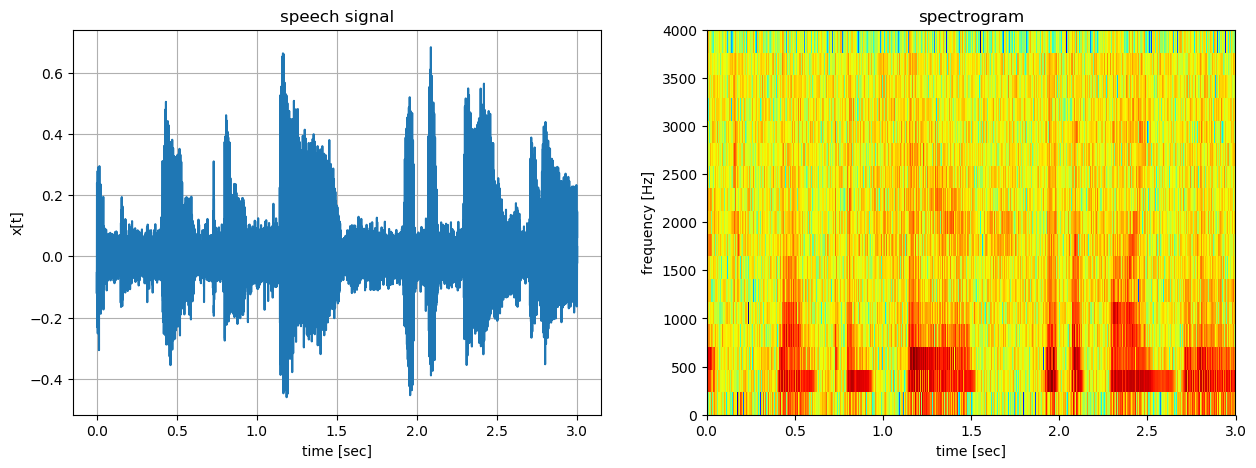

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()


@RV smin ~ GaussianMeanPrecision(placeholder(:μ_smin, dims = (2*freq_bins,)),
                                 placeholder(:Λ_smin, dims = (2*freq_bins,2*freq_bins)))
@RV Λw ~ ForneyLab.Wishart(placeholder(:v_Λw, dims = (2*freq_bins,2*freq_bins)), placeholder(:nu_Λw))
@RV s ~ GaussianMeanPrecision(smin, Λw)

@RV C
placeholder(C, :C, dims = (buffer_size,2*freq_bins))

# specify observations
@RV x = C*s

@RV y ~ GaussianMeanVariance(x, var_observation*Ic(buffer_size))

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10366917792019419795 -->
 10366917792019419795 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 1855997457843047451 -->
 1855997457843047451 
 
 placeholder_Λ_smin 
 
<!-- 10366917792019419795--1855997457843047451 -->
 10366917792019419795--1855997457843047451 
 
 Λ_smin 
 1 out 
 3 w 
 
<!-- 1910098188828252847 -->
 1910098188828252847 
 
 placeholder_μ_smin 
 
<!-- 10366917792019419795--1910098188828252847 -->
 10366917792019419795--1910098188828252847 
 
 μ_smin 
 1 out 
 2 m 
 
<!-- 16943970025215353593 -->
 16943970025215353593 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16943970025215353593--10366917792019419795 -->
 16943970025215353593--10366917792019419795 
 
 smin 
 1 out 
 2 m 
 
<!-- 15441466777928553629 -->
 15441466777928553629 
 
 W 
 wishart_1 
 
<!-- 16943970025215353593--15441466777928553629 -->
 16943970025215353593--15441466777928553629 
 
 Λw 
 1 out 
 3 w 
 
<!-- 10503405869678284238 -->
 10503405869678284238 
 
 placeholder_v_Λw 
 
<!-- 15441466777928553629--10503405869678284238 -->
 15441466777928553629--10503405869678284238 
 
 v_Λw 
 1 out 
 2 v 
 
<!-- 13872304997568127270 -->
 13872304997568127270 
 
 placeholder_nu_Λw 
 
<!-- 15441466777928553629--13872304997568127270 -->
 15441466777928553629--13872304997568127270 
 
 nu_Λw 
 1 out 
 3 nu 
 
<!-- 5434432574111886909 -->
 5434432574111886909 
 
 placeholder_C 
 
<!-- 3339031605549397329 -->
 3339031605549397329 
 
 clamp_1 
 
<!-- 14920496811489377754 -->
 14920496811489377754 
 
 × 
 multiplication_1 
 
<!-- 14920496811489377754--16943970025215353593 -->
 14920496811489377754--16943970025215353593 
 
 s 
 1 out 
 2 in1 
 
<!-- 14920496811489377754--5434432574111886909 -->
 14920496811489377754--5434432574111886909 
 
 C 
 1 out 
 3 a 
 
<!-- 16530918580558848433 -->
 16530918580558848433 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 16530918580558848433--3339031605549397329 -->
 16530918580558848433--3339031605549397329 
 
 clamp_1 
 1 out 
 3 v 
 
<!-- 16530918580558848433--14920496811489377754 -->
 16530918580558848433--14920496811489377754 
 
 x 
 1 out 
 2 m 
 
<!-- 900874564206513055 -->
 900874564206513055 
 
 placeholder_y 
 
<!-- 900874564206513055--16530918580558848433 -->
 900874564206513055--16530918580558848433 
 
 y 
 1 out 
 1 out

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization([smin, s], Λw, ids=[:s :Λw])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function steps!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 6))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_smin]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Λ_smin]))
messages[2] = ruleSVBGaussianMeanPrecisionOutVGD(nothing, messages[1], marginals[:Λw])
messages[3] = ruleSPMultiplicationOutNGP(nothing, messages[2], Message(MatrixVariate, PointMass, m=data[:C]))
messages[4] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=[0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

## Perform inference

In [8]:
messages=Array{Message}(undef, 6)
data = Dict()
marginals = Dict()

# set priors
μ_smin_min = zeros(2*freq_bins)
Λ_smin_min = 1e-3*Ic(2*freq_bins)
μ_s_min = zeros(2*freq_bins)
Λ_s_min = 1e-5*Ic(2*freq_bins)
v_Λw_min = 1e1*Ic(2*freq_bins)
nu_Λw_min = 2*freq_bins*10

# create marginals
marginals[:smin] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=μ_smin_min, w=Λ_smin_min)
marginals[:s] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=μ_s_min, w=Λ_s_min)
marginals[:Λw] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=v_Λw_min, nu=nu_Λw_min)

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    data[:C] = calc_C(freq, buf.buffer_t)*sqrt(buffer_size)
    data[:μ_smin] = μ_smin_min
    data[:Λ_smin] = Λ_smin_min
    data[:nu_Λw] = nu_Λw_min
    data[:v_Λw] = v_Λw_min
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(steps!, data, marginals, messages)  

    # get prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[3].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[3].dist))
    
    # infer parameters
    for it = 1:1
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(steps!, data, marginals, messages)  
        #marginals = Base.invokelatest(stepsmin!, data, marginals, messages)
        marginals = Base.invokelatest(stepΛw!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(μ_s, ForneyLab.unsafeMean(marginals[:s]))
    push!(Σ_s, ForneyLab.unsafeCov(marginals[:s]))
    
    # update hidden states
    μ_smin_min = ForneyLab.unsafeMean(marginals[:s])
    Λ_smin_min = ForneyLab.unsafePrecision(marginals[:s])
    v_Λw_min = marginals[:Λw].params[:v]
    nu_Λw_min = marginals[:Λw].params[:nu]
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:11


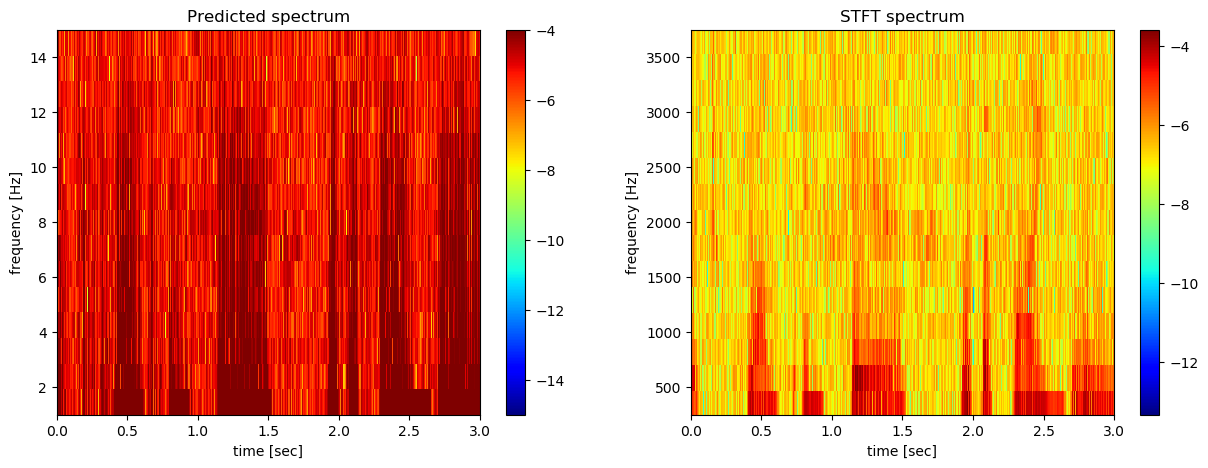

In [9]:
#convert μ_x to a 1d array
#μ_x_pred = expand((hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
vm = [-4,-15]
# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)],
                   vmin=vm[2], vmax=vm[1])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCs+F29pgP4vXE0xb2Kppq9gVNYvZnD7bwfnRI9wbyxPQv9HT6eDlw+zPR1Pl4qdT6o8Go+RptWPpxpTz2G6Sm9JXrxvJY6C75g0Wy+J5zuvbt4u70jVbC6nYoUveIVnTuV2pw9WnR1PfcHLbzv9Pc7mMBfvSJZ+rxqul69lS70vVmJ3L3Y9BG+7DgTvreabr09HuW8tvQbPESb4z3rqBo+SGZiPrVfUj4xJIA+qOOOPl0B/D1DLNY8ita5PJVYP7tg4gu+JQWBvkCLXr4MPMu9w13pvM50fr2yE0q9Q9kUPS13az2BSsC7LKSSPOO9JL21qUK9/dPJvd+ykbxiIg++G6X8vdnyEL7zMoC92gmIvUA5Mj0fFIc9N7xqPqdiWD6mYZU+JWlcPqsIQz4sxFs9HrVkPZ69eD0NTiu9V+hjvl1sVr68Tum93IXBvXEPNb3cjsm8pSJmOvzimT105ZI96PUMPe4oSr310Le7uFqau8kVy71brT6+NYdYvelN0L1RaL69kXSIvKNLXLuVqKw95eDpPdTdKj5faG0+WYt6PnIrhD6mshc9X6/LPHpAWT0KVpq8R7YpvjXznL4u2Cq+XKLrvbaOsL3j5tm9B6FWvVvNpzzcVmU8o7BDPV2jrjwcn8S7Rl8APVzxRL3q6cC9Q8XcvTYKS70cV4C9EE6ZvWQWvTyL7io+0Q+XPhO1ej5xG04+YVknPgfljD1D/r490HAwO8zjJ76V4ze+MYjMvakUG76yAza+oSdgvWXHCL1HW0s9DAkmu7/5iz3YYY49rxuWPTcknj1hyZo9Nu8Yvq9EDr72Kpi9C7uavaOxMr4HIhC+Qg0uvbQ/Ez1TTnY8LGy4PVt/9j3V9CE+1zwRPn8bHz5kc+A9QgiCPc5aML3zIuM8yjIQvb4MZb1STNO9LjQpvrI45b0oRca9VPjhvQBRkr3+xV49v6IIvUWGAT3agoi9fedPPQ33Kb0czoi8xRTYPP2ZvLx5g6g9+oQ9Pme/QT42FXE+Eb1gPr5EXj6Jlrk9b7aKOw/0Er3W0K69sBJAvgP0Hr6DKOC9arrXvXKA6L1SqDq9LyDfPfXK2D3D+Yw9iBxDPamMzD3X4fM9ilR9PBR0sjyTi4K9kGFkvV3Xj71T1p+93wwovuJW2b1ZcMW9SON9vKBDgb3pTJC9gGeZPYX2SD0UHw89UhNePSIh9Lyjf388fpvgvL1Aib3frr69oYxKva8EqTs8i+C836jIPOf6gj3Yh448nauhPF7ACD0mHpu8huS9PG4wkbwKfoS9V6wKvcwh8buRM3+9tklTPKtBgLwDh0E8bL+cPdeGObwX6Kc9rOnRPN/cU7wal4A96Xz7POXlaT2ZiHM8SOmrOxrONr2O4MC7bgCevRoNIL0J61G7n4yKvD7h6L2ZPya9kTBIPX4lMDwgtbS9MkrFvFEcITwNrRM9H2RHvLRNbTwtmW09aizJPe3ogT0FjaM9+ohSPeh+gj1Pl2s9eORpPcLn17z4dgO9ziSXvb6u/b107Ay+Xy2WvfKqt73+JGK9HtpPvVhajr3KYma9fobzvJ0LVby0udQ7tC4CO/rduzy4izM9/qsIPpn8gD1SGtc9hIDJPU0Lyz3FYQs+VF06vbFjnLyaINy7hD3Cvaa/Cb3pmaa9pdirvdFg370v2c29H/BvvZfGU71TpZy9YWVnvTSuHj39KDa8/oa7PLf5Vj16J6g92g83PZN8mT1D2B8+2WZHPtTz6z0LA6k9nYqOPe9MFTxL3Co9/NkNvSvAMb4lddq8VkEvvcJWqr2GUqa9ROlwvcNjLj1CtIm9rQMEPS7hrD1t53M9SuhFPYKnqDuF9ck9f/nOO930vjv+UGO8uq0gPZQAi70VmcW7/c9BvVnnrL06KDK9RPRbvTuV/rzTcoK7+LQJvSSveLiWOqS89TUwPdV/wDwWxgM8as8hPcIbQbxFDDa9hnGEvPxg8TxNYha8qx1LPSnc9TwR18O7Ee8yvU8mjTy9kD479P+TvLg4t7qTvWc8EdfLvJ8KX7zg3pc816KDPZls9rttCgU9C9mHPfiEkrq/Jrw9AYO4PDNzHj2Q4dM8qB4Tu62oW7xmoLM8Yq36vMnQkzwM9Uc939DvvNmEibwTcgM9pMrAvC9auL20caO8DnuMPYUwkTqTu608gHowPdXywzs8B2k8YBQNPXryJD2OSnq78GaivAI8fr11nI48H4+oPHhIVz0N2gc9Q8ryu4f9X72cBeU7m+U0PamrX7xkXT29ATZzPGawKr1PqIQ7qP62vEcsDT1YTCI9Cf9SPABKdT3S8pc8kDpHPaQjDD03aIs9G+UfO5BFibxWle88rxhZvUVXCz1HwTg9196+O3ikzjyrmRw9aSStvNP92Lsg8rS8TBL3PGFAszySgaG8JzwOPSY4nrxFQo687dPJvN5gsLxZs5Q9SQEWvWZTLjyn8cq8Y6vnvMbxmj3lggm9xrqWPGfTBTwBo6c7z4Q2uh9Jsz0f1Qg9vS/8vOo60bzbVSG9skpyuhJoWb0H0N28KuM0PTLYPL2Whws99/UHPX50mrv99+c8zNVnvafGLD2atlI8fewrPVcWWjyzOAm9IQXqvHU/Prztb9m8Zz//PKOZAL1ldZS9Em+JPNCXiL194rC8s7/jvWppkr1sTEu9hNWNuTyymryy4qO82svCu6NyYjz0d1Q8y6l2vJNsDb00jak86n/mvLg44rrydOs7gDoEvd8ssTwddFg9QGlpPfJTpzyBg9k8/aOvPPCVejygvay8ymRwPCTD3rzYr5Q835gWvTqVVTwpHNQ8a5FvvfxxAb1UChw9yLQnu6LquLxz8T68kQ5oPeVAGb16gvE7s5a7vOx1BT3bDZE9bMpZvUzXGLwdcdE8YxyHPKvLUzxi7RQ7k23zOl1s9rzCezw7Wr6iPGtKVL1+x428oH8SvP3hWTp+lYO8yF+ivf9WELxL1GA8LT5+vcKQXDxfsSu98Jc/PRXZW71dNqU8BU5KvAAMArxFP4w895+uPLXmlLxgtac6yRqNPIGxljwM+KQ8/NLCOxxs07yHXCc78dvZu2ZxwTwtSvc8WDToPApZRD3EkWu8NVAzPQFWyLxPRho9GeFcO8ieIz3ZzOE77MMgPQylHjtePfu8EhcUvL7p2rwi87Y83DkivXtuPjxTsdE8Hs2rvNmH4TtpMZc9jP57uX/usDyVvAw9HJaUPNRBa7wLdCM9o8G/vO3nTT1lAhW9L7eTu+eqCL2MyFK9kN3IvN6Z/jzcEYW8ai7vvOdi9LxgRrU86X4RPR3FcTvPti29kKafPDazijpdOaa5zcIAvHghmrwT9Jw8k8CBvAUR4ztjsI88gzTmvLDWeTwOLAC8nPukuw1p6LwrHm080JIkPBg9ubsMyTC8CJFbvKGWX7xARzU8ctCQvOzmMbxIZpy8MJFMvJy8XLsEevW8MLGCPMtgRLnHHsm7ykShvM2kO70YDsq7glQjuwpXULs4V7i8lS+QPD24trzrGve8j9UpvL4W/bxSwPQ8ca+DvOq+Mj3UYw27TETwvLPSAT2HFXk9QYw8veK2x7xiFWa7IgjOvA4EkL3TbbO8BredPQWz6DxGFH48QwGBvZ3yqLyddSW9ab4JvVwBDr29CQi980dHvOK/tjxag+U6rf5wPS5YJj2Cl6C9rk7qO1/jtzuSuoO9Nxc0vNbkuzy/HSA9V8C9PF/yDTvXFpc8wbgivFsuqTz9Iky94u3sPPt2G72Jdce8DGMXPUn13zzUWqg6XJACvFHPILy4l3M8PJsBORGXWDuJhXy8B3T2uxu5fT0Vkko91BAfPfqVTzuU8pU9HG9WvZL+o7yhyeW87Y+WPC8ltru1jWQ9yvfBu8eqsTu+E

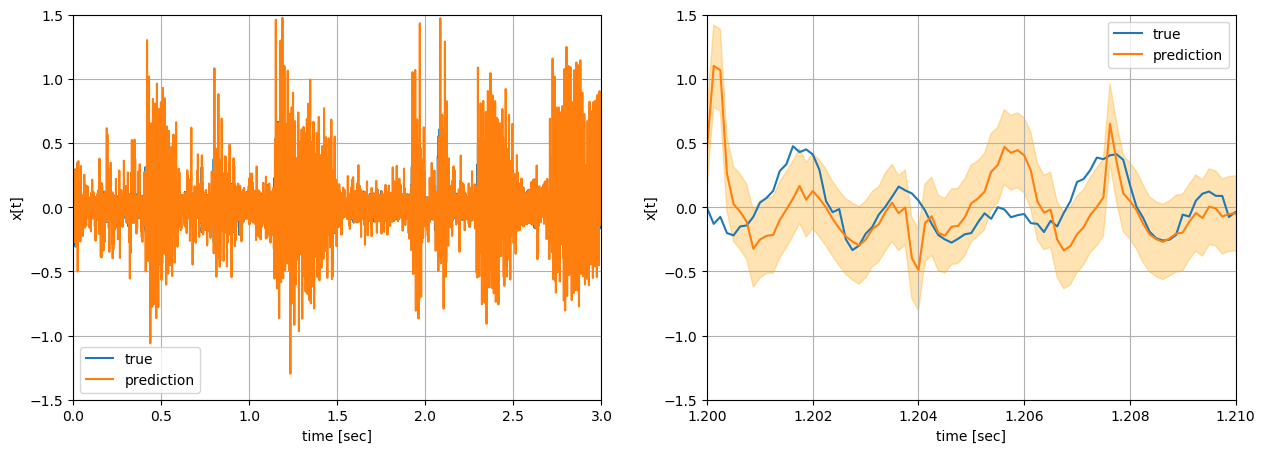

In [10]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

μ_x_pred_select = simplify(reverse(hcat(μ_x...), dims=1))
var_x_pred_select = expand([reverse(diag(Σ_x[k])) for k =1:length(Σ_x)])

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[1:length(μ_x_pred_select)], μ_x_pred_select .- sqrt.(var_x_pred_select), μ_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.2,1.21), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, x_time_clean, μ_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [11]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]).^2)

0.02859308897842669

In [12]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]))

0.10690586177401779

In [13]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, sum([1/buffer_size*logpdf(Distributions.Normal(μ_x[k][ki], sqrt(Σ_x[k][ki,ki])), buf.buffer_s[ki]) for ki=1:buffer_size]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 799       mean:0.11763389330250965